In [48]:
#import packages
import hyperspy.api as hs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display
from ipywidgets import Button
%matplotlib ipympl

In [3]:
# load data 
filepath = './'#r'/masc_shared/ag_volz/haust/Thermo_EELS_ncm_linbo3/Marburg Sample HT and LT demo Selectris EELS data/Sample LT/HR CL/raw_data'
file = 'mos2ws2_21mslowloss8_converted'#'O Mn'
file_ending = '.hspy'

signal_raw = hs.load(filepath+'/'+file+file_ending)
# normlalise data
signal_raw = signal_raw/np.max(np.asarray(signal_raw))

In [16]:
signal_raw.metadata

├── General
│   ├── FileIO
│   │   ├── 0
│   │   │   ├── hyperspy_version = 2.0.1
│   │   │   ├── io_plugin = rsciio.hspy
│   │   │   ├── operation = save
│   │   │   └── timestamp = 2024-03-26T15:08:09.755165+01:00
│   │   └── 1
│   │       ├── hyperspy_version = 2.0.1
│   │       ├── io_plugin = rsciio.hspy
│   │       ├── operation = load
│   │       └── timestamp = 2024-04-17T14:25:16.235597+02:00
│   └── title = 
└── Signal
    └── signal_type = EELS

In [17]:
signal_raw.axes_manager

Navigation axis name,size,index,offset,scale,units
,250,0,0.0,1.0,
,122,0,0.0,1.0,
Signal axis name,size,,offset,scale,units
,281,,-5.00088524590164,1.0,


In [52]:
# Calibrate Signal if necessesary 
print("Type y is you want to change the data calibration")
answer = input()

if answer == 'y':
    signal_raw.axes_manager[0].name = 'x'
    signal_raw.axes_manager[0].scale = 1
    signal_raw.axes_manager[1].name = 'y'
    signal_raw.axes_manager[0].scale = 1
    signal_raw.axes_manager[2].name = 'Energy loss'
    signal_raw.axes_manager[0].scale = 1
    print("Calibration changed")
    
else:
    print('abborted')

Type y is you want to change the data calibration


abborted


In [53]:
signal_raw.axes_manager

Navigation axis name,size,index,offset,scale,units
x,250,0,0.0,1.0,
y,122,0,0.0,1.0,
Signal axis name,size,,offset,scale,units
Energy loss,281,,-5.00088524590164,1.0,


## Plot EELS spectra

In [24]:
signal_raw.plot()

## Align Zero Loss Peak 

In [34]:
help(signal_raw.align_zero_loss_peak)

Help on method align_zero_loss_peak in module exspy.signals.eels:

align_zero_loss_peak(calibrate=True, also_align=[], print_stats=True, subpixel=True, mask=None, signal_range=None, show_progressbar=None, crop=True, **kwargs) method of exspy.signals.eels.EELSSpectrum instance
    Align the zero-loss peak.
    
    This function first aligns the spectra using the result of
    `estimate_zero_loss_peak_centre` which finds the maximum in the
    given energy range, then if subpixel is True,
    proceeds to align with subpixel accuracy using `align1D`. The offset
    is automatically correct if `calibrate` is True.
    
    Parameters
    ----------
    calibrate : bool
        If True, set the offset of the spectral axis so that the
        zero-loss peak is at position zero.
    also_align : list of signals
        A list containing other spectra of identical dimensions to
        align using the shifts applied to the current spectrum.
        If `calibrate` is True, the calibration is a

In [5]:
signal_raw.align_zero_loss_peak(calibrate=True, 
                                      also_align=[], 
                                      print_stats=True, 
                                      subpixel=True, 
                                      mask=None, 
                                      signal_range=None, 
                                      show_progressbar=None, 
                                      crop=True)

Initial ZLP position statistics
-------------------------------
Summary statistics
------------------
mean:	-4.3e-16
std:	0.401

min:	-0.201
Q1:	-0.201
median:	-0.201
Q3:	-0.201
max:	0.799
[########################################] | 100% Completed | 2.02 ss
[########################################] | 100% Completed | 3.24 ss
[########################################] | 100% Completed | 1.11 ss


## Substract Background

In [9]:
signal_background_corrected, background_modell = signal_raw.remove_background(signal_range=(410,530), 
                    background_type='Power law', 
                    polynomial_order=3, 
                    fast=True, 
                    zero_fill=False, 
                    plot_remainder=False, 
                    show_progressbar=None, 
                    return_model=True,
                    display=False, 
                    toolkit=None)

# normalise signal again
signal_normalised = signal_background_corrected/np.max(np.asarray(signal_background_corrected))


background_modell.plot(plot_components=False, plot_residual=True)

## Deconvolution

In [8]:
if "signal_normalised" not in locals():
    signal_normalised = signal_raw.copy()

# deconvolution for zero loss
signal_deconvolved= signal_normalised.fourier_ratio_deconvolution(
                                ll = signal_raw, 
                                  fwhm=None,  # None
                                  threshold=None, 
                                  extrapolate_lowloss=False, #
                                  extrapolate_coreloss=False)
signal_deconvolved.plot()

[########################################] | 100% Completed | 449.89 ms


## Filter and smoth Data 

In [14]:
signal_filtered = signal_deconvolved.copy()
signal_filtered.gaussian_filter(FWHM= 1.5) 
signal_filtered.plot()

In [17]:
signal_filtered = signal_deconvolved.copy()
signal_filtered.filter_butterworth(cutoff_frequency_ratio=0.2, 
                                   type='low',
                                   order=2, 
                                   display=True, 
                                   toolkit=None)
signal_filtered.plot()

In [26]:
signal_filtered = signal_deconvolved.copy()
signal_filtered.smooth_lowess(smoothing_parameter=0.1, 
                              number_of_iterations=2, 
                              show_progressbar=None, 
                              num_workers=36, 
                              display=True, 
                              toolkit=None)
signal_filtered.plot()

[########################################] | 100% Completed | 6.34 ss


In [38]:
signal_filtered = signal_deconvolved.copy()
signal_filtered.smooth_savitzky_golay(polynomial_order=6, 
                                      window_length= 5, 
                                      differential_order=0, 
                                      num_workers=36, 
                                      display=True,
                                      toolkit=None)
signal_filtered.plot()

In [36]:
signal_filtered = signal_deconvolved.copy()
signal_filtered.smooth_tv(smoothing_parameter=6., 
                          show_progressbar=None, 
                          num_workers=36, 
                          display=True, 
                          toolkit=None)
signal_filtered.plot()

[########################################] | 100% Completed | 101.84 ms
[########################################] | 100% Completed | 201.95 ms
[########################################] | 100% Completed | 202.00 ms
[########################################] | 100% Completed | 301.40 ms
[########################################] | 100% Completed | 1.41 ss
[########################################] | 100% Completed | 1.42 s
[########################################] | 100% Completed | 1.51 s
[########################################] | 100% Completed | 1.51 s
[########################################] | 100% Completed | 1.51 s


## Save Results 

In [55]:
file_ending = '.hspy'
signal_filtered.save(filepath+'/'+file+'_processed'+file_ending)

## Plot Peak Map

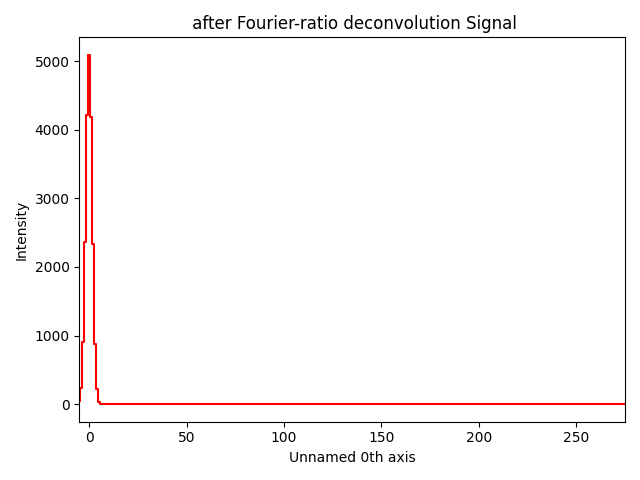

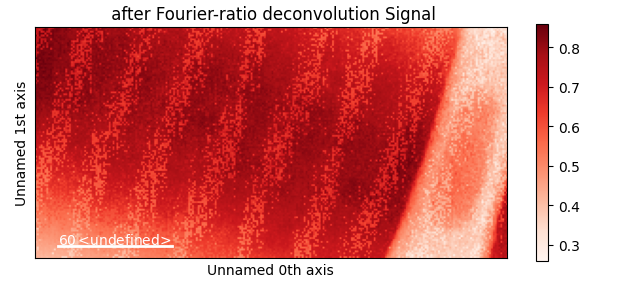

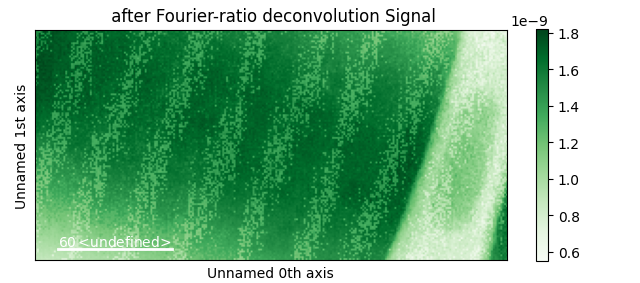

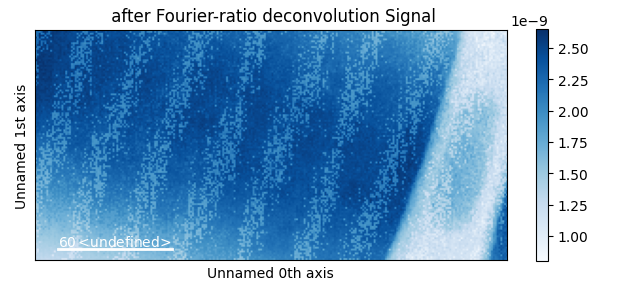

In [13]:
if "signal_filtered" not in locals():
    signal_filtered = signal_deconvolved.copy()
all_sum, rois, roi_signals, roi_sums = hs.plot.plot_roi_map(signal = signal_filtered, rois = 3)

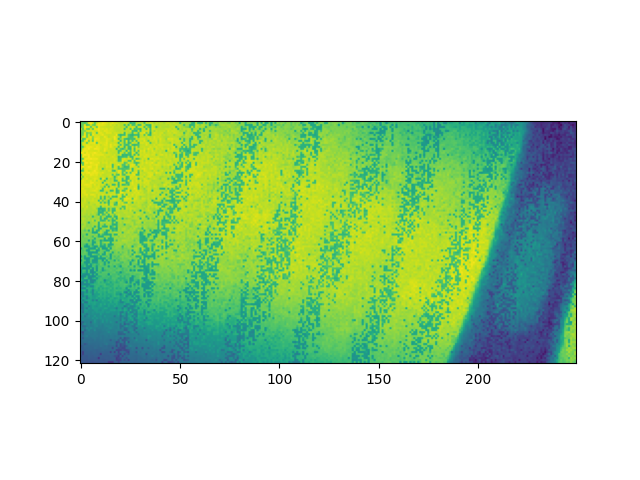

In [12]:
image = np.asarray(roi_sums)
fig, ax = plt.subplots()
for i in range(image.shape[0]):
    ax.imshow(image[i,:,:])
plt.show()